In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os

In [2]:
# remove all saved images in the current directory
for file in os.listdir():
    if file.endswith('.png'):
        os.remove(file)
# remove all saved images in the directory TestCase1
for file in os.listdir('./TestCase1/'):
    if file.endswith('.png'):
        os.remove('./TestCase1/' + file)

### Exact Solution

In [3]:
BL = 1e-1
N = 65
def exactSol(x, y):
    return x*y*y - y*y*np.exp((2*(x - 1))/BL) - x*np.exp(3*(y - 1)/BL) + np.exp((2*(x - 1) + 3*(y - 1))/BL)

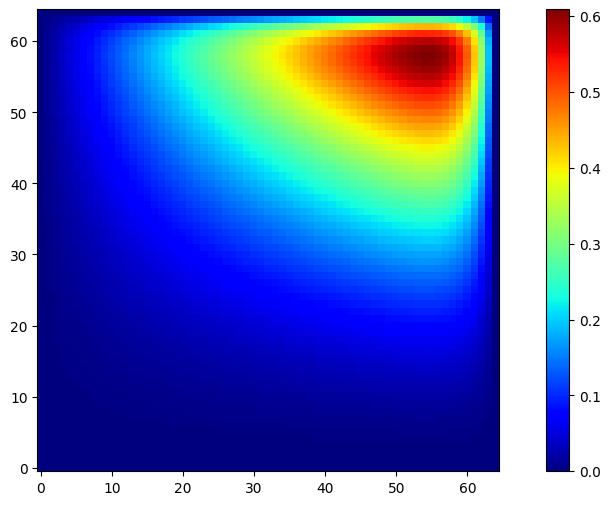

(65, 65)


In [4]:
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
Z = exactSol(X, Y)

plt.figure(figsize=(12, 6))
plt.imshow(Z, cmap='jet', origin='lower')
plt.colorbar()
plt.show()
print(Z.shape)

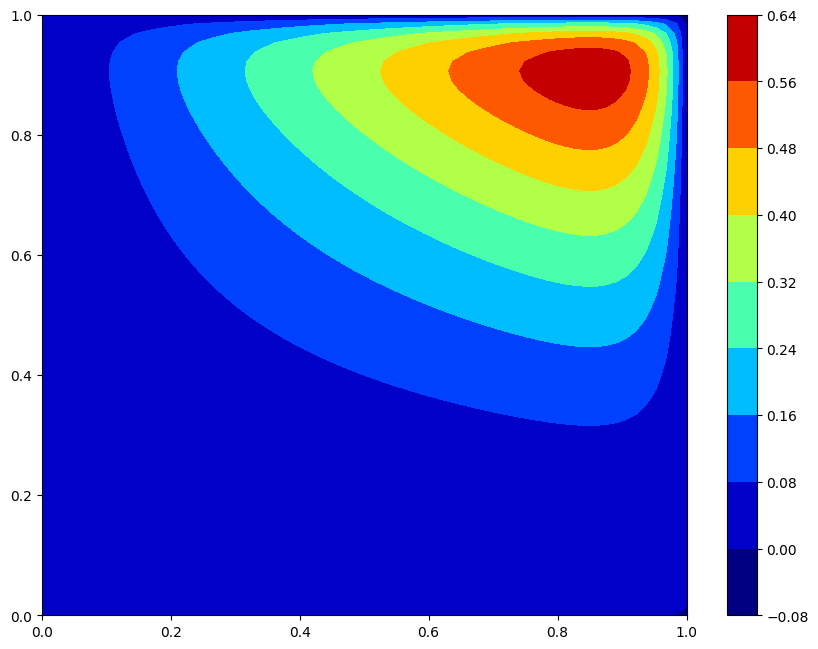

In [5]:
k = 1.3
plt.figure(figsize=(8*k, 6*k))
cp = plt.contourf(X, Y, Z, cmap='jet', vmin=0)
plt.colorbar(cp)  # Add a colorbar
plt.savefig('exacsfield.png') 
plt.show()

### Plot Solutions

In [6]:
def plots2D(Z, title = 'plot', vmin=None, vmax=None):
    N = Z.shape[0]
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(12, 6))
    im = plt.imshow(Z, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    cbar.set_label('Function Value')

    plt.tight_layout()
    plt.savefig( './TestCase1/' + title + '.png')  # Save as PNG
    # plt.savefig('./TestCase1/' + title + '.svg')  # Save as SVG
    plt.show()

In [7]:
def plots2Dcontour(Z, title = 'plot', vmin=None, vmax=None, colormap='jet'):
    N = Z.shape[0]
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(8*1.2, 6*1.2))
    cp = plt.contourf(X, Y, Z, cmap=colormap, vmin=vmin, vmax=vmax)
    plt.colorbar(cp)  # Add a colorbar
    plt.savefig( './TestCase1/' + title + '.png')  # Save as PNG
    plt.show()

In [ ]:
# copy file fdaPDE_SUPG_sol.txt from the build directory to the current directory with shutil
try:
    os.makedirs('TestCase1')
except:
    pass
fdaPDE_SUPG_sol  = '../../../fdaPDE-core/test/build/fdaPDE_SUPG_sol.txt'
shutil.copy(fdaPDE_SUPG_sol, './TestCase1/fdaPDE_SUPG_sol.txt')

In [ ]:
path = 'TestCase1/fdaPDE_SUPG_sol.txt'
# path = 'TestCase1/fdaPDE_SUPG_sol_no_stab.txt'
# path = 'TestCase1/fdaPDE_SUPG_sol_pert.txt'
data = np.loadtxt(path, delimiter=',')
print(data.size)
N = int(np.sqrt(data.size))
print("N = ", N)
data = data.reshape(N,N)
plots2D(data, 'TestCase1_sol')
print(data.shape)

In [ ]:
plots2Dcontour(data, 'TestCase1_sol_contour')

In [ ]:
# check error between femR and exact
femR_error = np.abs(data - Z)
norm_error_2 = np.linalg.norm(femR_error, 2)
norm_error_inf = np.linalg.norm(femR_error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)
plots2D(femR_error, 'TestCase1_error')

In [ ]:
plots2Dcontour(femR_error, 'TestCase1_femR_error_contour', colormap='jet')

### Save locations and observations for FreeFEM

In [ ]:
n = 5
while n <= 25:
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    locs = np.array([x.flatten(), y.flatten()]).T     # careful with the ordering
    # locs = np.array([y.flatten(), x.flatten()]).T       # careful with the ordering

    np.savetxt('../data/transport/testPsi/locs' + str(n) + '.txt', locs.flatten(), delimiter=',', fmt='%.6f')

    observations = exactSol(locs[:,0], locs[:,1])
    np.savetxt('../data/transport/testPsi/observations' + str(n) + '.txt', observations, delimiter=',', fmt='%.16f')
    n += 5

In [ ]:
# check the last observation
plots2D(observations.reshape(25,25))

In [ ]:
expected = np.copy(Z.flatten())
np.savetxt('../data/transport/testPsi/expected.txt', expected, delimiter=',', fmt='%.16f')

In [ ]:
plots2D(expected.reshape(65,65))

### Delete previous observations and files

In [ ]:
# delete a directory and all its content
shutil.rmtree('../data/transport/TransportTestCase1')
# recreate the directory empty
os.makedirs('../data/transport/TransportTestCase1')

### Save observations and locations

In [ ]:
n = 5
while n <= 25:
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    locs = np.array([x.flatten(), y.flatten()]).T # row major ordering
    
    observations = exactSol(locs[:,0], locs[:,1])
    row_indices = np.arange(1, n*n + 1)
    result_matrix = np.column_stack((row_indices, observations))
    column_names = np.array(['', 'x'])
    result_matrix = np.vstack((column_names, result_matrix))
    np.savetxt('../data/transport/TransportTestCase1/observations' + str(n) + '.csv', result_matrix, delimiter=',', fmt='%s')
    
    locs = np.column_stack((row_indices, locs))
    column_names = np.array(['', 'V1', 'V2'])
    locs = np.vstack((column_names, locs))
    np.savetxt('../data/transport/TransportTestCase1/locs' + str(n) + '.csv', locs, delimiter=',', fmt='%s')
    n += 5

### Save `excpected()` from the exact solution

In [ ]:
expected = np.copy(Z)
N = expected.size
row_indices = np.arange(1, N + 1)
expected = np.column_stack((row_indices, expected.flatten())) # row major ordering
column_names = np.array(['', 'x'])
expected = np.vstack((column_names, expected ))
np.savetxt('../data/transport/TransportTestCase1/expected.csv', expected, delimiter=',', fmt='%s')

### Plot `model.f()`

In [ ]:
try:
    shutil.rmtree('./TestCase1/modelf/')
except:
    pass
os.makedirs('TestCase1/modelf/')

for file in os.listdir('../build/'):
    if file.startswith('modelf'):
        shutil.copy('../build/' + file, './TestCase1/modelf/' + file)
        

In [ ]:
# path  = '../../fdaPDE-cpp_Carlotta/fdaPDE-cpp/test/build/'
path  = './TestCase1/modelf/'
average_modelf = 0
n = 5
while n <= 25:
    modelf = np.loadtxt(path + 'modelf' + str(n) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    average_modelf += modelf
    # plots2D(modelf, 'TestCase1_modelf' + str(n))
    n += 5
average_modelf /= 5
print('average model.f()')
plots2D(average_modelf, 'TestCase1_modelf_average')

In [ ]:
# print the five model_f()s in a subplot
plt.figure(figsize=(25, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    modelf = np.loadtxt(path + 'modelf' + str(5*(i+1)) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    plt.imshow(modelf, cmap='jet', origin='lower')
    plt.title('model.f(), ' + str(5*(i+1)) + ' obs')
    plt.colorbar()
    
# save the plot
plt.tight_layout()
plt.savefig('model_f_subplot_pert_1e5.png')
plt.show()

In [ ]:
# plot the error of the five model_f()s in a subplot
plt.figure(figsize=(25, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    modelf = np.loadtxt(path + 'modelf' + str(5*(i+1)) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    error = np.abs(modelf - Z)
    norm_error_2 = np.linalg.norm(error, 2)
    norm_error_inf = np.linalg.norm(error, np.inf)
    print("norm2 = ", norm_error_2)
    print("norm_inf = ", norm_error_inf)
    plt.imshow(error, cmap='jet', origin='lower')
    plt.title('model.f(), ' + str(5*(i+1)) + ' obs')
    plt.colorbar()

### Import & plot $\texttt{model.f()}$ from FreeFEM

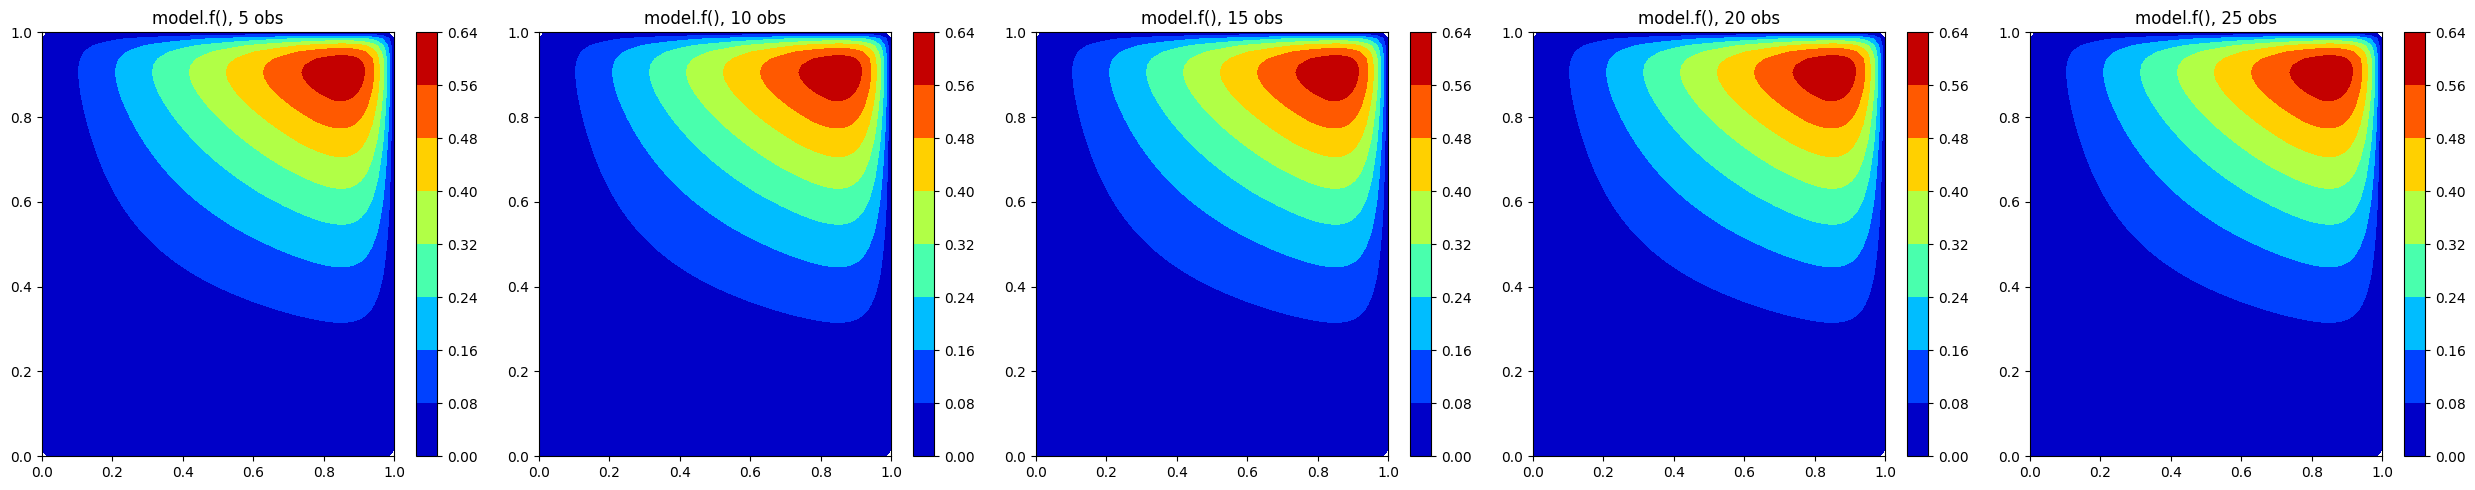

In [11]:
path = '../data/transport/testPsi/'
plt.figure(figsize=(25, 5))
# define X and Y
x = np.linspace(0, 1, 65)
y = np.linspace(0, 1, 65)
X, Y = np.meshgrid(x, y)
for i in range(5):
    plt.subplot(1, 5, i+1)
    modelf = np.loadtxt(path + 'modelf_' + str(5*(i+1)) + '.txt', delimiter=',')
    N = int(np.sqrt(modelf.size))
    modelf = modelf.reshape(N,N)
    # plt.imshow(modelf, cmap='jet', origin='lower')
    cp = plt.contourf(X, Y, modelf, cmap='jet', vmin=0)
    # plt.colorbar(cp)
    plt.title('model.f(), ' + str(5*(i+1)) + ' obs')
    plt.colorbar()
plt.tight_layout()
plt.savefig('model_f_subplot_freeFEM_stab23.png')
plt.show()

In [ ]:
# k fold cross validation, PDE perturbed, delta = 1e5 (k fold always chooses lambda = 1e-3)

In [ ]:
# k fold cross validation, PDE exact, delta = 1e5

In [ ]:
# k fold cross validation, PDE exact, delta = 6.03

In [ ]:
# k fold cross validation, PDE exact, delta = 23.294

In [ ]:
plots2Dcontour(average_modelf, 'TestCase1_modelf_average_contour')

In [ ]:
# model f with stabilization parameter delta = 5e4

In [ ]:
# modelf with stabilization parameter delta = 1e5

In [ ]:
# model.f with stabilization parameter delta = 1e4

In [ ]:
# model f() error without stabilization (le osservazioni aumentano)

In [ ]:
# compute error between model.f() and the exact solution (data)
modelf = np.copy(average_modelf)
# error = np.abs(modelf - data)
error = np.abs(modelf - data) #Z)
# compute norm2 and norminf of the error
norm_error_2 = np.linalg.norm(error, 2)
norm_error_inf = np.linalg.norm(error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)
# plots2D(error, 'TestCase1_error') # , vmin=0, vmax=0.012)

In [ ]:
plots2Dcontour(error, 'TestCase1_error_contour')

In [ ]:
# k fold cross validation, PDE perturbed, delta = 1e5 (k fold always chooses lambda = 1e-3)

In [ ]:
# model.f() error with stabilization parameter delta = 5e4

In [ ]:
# model.f() error with stabilization parameter delta = 1e5

In [ ]:
# model.f() error con stabilization parameter delta = 1e4

Sembra che all'aumentare del numero di osservazioni, il problema diventi ancor più a trasporto dominante.

### Boxplots

In [ ]:
directory_testcase = './TestCase1/'
# build directory
directory_build = '../build/'
# remove directory and its content
try:
    shutil.rmtree(directory_testcase + 'RMSEs/')
except:
    pass
# recreate emtpy directory
os.makedirs(directory_testcase + 'RMSEs/')
# copy all .csv files from the directory .../build to the current directory
for file in os.listdir(directory_build):
    if file.endswith('.csv'):
        shutil.copy(directory_build + file, directory_testcase + 'RMSEs/') 

In [ ]:
data = {}
i = 5
while i <= 25:
    current = np.loadtxt(directory_testcase + 'RMSEs/RMSE_' + str(i) + '.csv')
    data[i] = current
    i += 5

plt.figure(figsize=(12, 6))
plt.boxplot(data.values())
plt.xticks(range(1, len(data.keys()) + 1), data.keys())
plt.savefig('./TestCase1/TestCase1_boxplots_pert_stab=1e5.png')
plt.show()

In [ ]:
# even with more observation the problem without stabilization still explodes

In [ ]:
# more observation to cover (apparently) the fact that the problem is more transport dominated. I think error is still acceptable

In [ ]:
# pde perturbed and stabilized too much (i.e. wrong) lambda = 1e-3

In [ ]:
# k fold cross validation, PDE perturbed, delta = 6.03 (k fold chooses PDE more with more observations)

In [ ]:
# k fold cross validation, PDE perturbed, delta = 1e5 (k fold always chooses lambda = 1e-3)

In [ ]:
# k fold cross validation, PDE exact, delta = 1e5

In [ ]:
# k fold cross validation, PDE exact, delta = 6.03

In [ ]:
# k fold cross validation, PDE exact, delta = 23.294

In [ ]:
# lambda = 1e-3, delta = 1e5

In [ ]:
# lambda = 1e-3, delta = 5e4

In [ ]:
# lambda = 1e-3, delta = 1e5

In [ ]:
# lambda = 1e-3, delta = 1e4

#### Prepare test locations different from mesh nodes when you have exact solution

In [ ]:
# test locations for the gridf
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
z = np.array([[i, j] for i in x for j in y])
observations = exactSol(z[:,0], z[:,1])
row_indices = np.arange(1, n*n + 1)
result_matrix = np.column_stack((row_indices, observations))
column_names = np.array(['', 'x'])
result_matrix = np.vstack((column_names, result_matrix))
np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase0/test_values.csv', result_matrix, delimiter=',', fmt='%s')

z = np.array([[j, i] for i in x for j in y])
z = np.column_stack((row_indices, z))
column_names = np.array(['', 'V1', 'V2'])
z = np.vstack((column_names, z))
np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase0/test_locs.csv', z, delimiter=',', fmt='%s')


In [ ]:
# compare error between gridf and exact solution
gridf_exact = observations.reshape(100, 100).T # this transpose is the reason why I need to invert z to save the locations
plots2D(gridf_exact, 'gridf_exact')

In [ ]:
# put in a subplot 2x2 both gridf and observations transposed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gridf, cmap='jet', origin='lower')
plt.title('FEM interpolation of model.f()')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(gridf_exact, cmap='jet', origin='lower')
plt.title('exact sol')
plt.colorbar()
plt.tight_layout()
# save plot
plt.savefig('gridf_gridf_exact.png')
plt.show()


In [ ]:
# compute error between model.f() and the exact solution (data)
error = np.abs(gridf - gridf_exact)
# compute norm2 and norminf of the error
norm_error_2 = np.linalg.norm(error, 2)
norm_error_inf = np.linalg.norm(error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)

In [ ]:
plots2D(error, 'gridf_error')

### Interpolate result of perturbed PDE

In [ ]:
# import data form perturbed PDE
try:
    os.makedirs('TestCase1')
except:
    pass
fdaPDE_SUPG_sol  = '../../../fdaPDE-core/test/build/fdaPDE_SUPG_sol.txt'
shutil.copy(fdaPDE_SUPG_sol, './TestCase1/fdaPDE_SUPG_sol_perturbed.txt')

In [ ]:
path = 'TestCase1/fdaPDE_SUPG_sol_perturbed.txt'
# path = 'TestCase1/fdaPDE_SUPG_sol_no_stab.txt'
data = np.loadtxt(path, delimiter=',')
print(data.size)
N = int(np.sqrt(data.size))
print("N = ", N)
data = data.reshape(N,N)
plots2D(data, 'TestCase1_sol')
print(data.shape)

In [ ]:
plots2Dcontour(data, 'TestCase1_sol_contour_perturbed')

In [ ]:
# compute errro with exact solution
error = np.abs(data - Z)
# compute norm2 and norminf of the error
norm_error_2 = np.linalg.norm(error, 2)
norm_error_inf = np.linalg.norm(error, np.inf)
print("norm2 = ", norm_error_2)
print("norm_inf = ", norm_error_inf)
plots2D(error, 'TestCase1_perturbed_error')

In [ ]:
plots2Dcontour(error, 'TestCase1_perturbed_error_contour')

In [ ]:
from scipy.interpolate import RegularGridInterpolator
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
interpolating_function = RegularGridInterpolator((x, y), data, method='linear')

### Save locations and observations for FreeFEM format  (perturbed PDE)

In [ ]:
n = 10
while n <= 70:
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    # locs = np.array([x.flatten(), y.flatten()]).T     # careful with the ordering
    locs = np.array([y.flatten(), x.flatten()]).T       # careful with the ordering

    np.savetxt('../data/transport/testPsi/locs' + str(n) + '.txt', locs.flatten(), delimiter=',', fmt='%.6f')

    observations = interpolating_function(locs)
    np.savetxt('../data/transport/testPsi/observations' + str(n) + '.txt', observations, delimiter=',', fmt='%.16f')
    n += 20

In [ ]:
plots2D(observations.reshape(70,70))

In [ ]:
n = 6
while n <= 14:
    t = np.linspace(0, 1, n)
    x, y = np.meshgrid(t, t)
    # locs = np.array([x.flatten(), y.flatten()]).T # row major ordering
    locs = np.array([y.flatten(), x.flatten()]).T # column major ordering
    
    observations = interpolating_function(locs) #locs[:,0], locs[:,1])
    row_indices = np.arange(1, n*n + 1)
    result_matrix = np.column_stack((row_indices, observations))
    column_names = np.array(['', 'x'])
    result_matrix = np.vstack((column_names, result_matrix))
    np.savetxt('../data/transport/TransportTestCase1/observations' + str(n) + '.csv', result_matrix, delimiter=',', fmt='%s')
    
    locs = np.column_stack((row_indices, locs))
    column_names = np.array(['', 'V1', 'V2'])
    locs = np.vstack((column_names, locs))
    np.savetxt('../data/transport/TransportTestCase1/locs' + str(n) + '.csv', locs, delimiter=',', fmt='%s')
    n += 2

In [ ]:
plots2D(observations.reshape(14,14))

### Save $\texttt{expected()}$ for FreeFEM format (perturbed PDE)

In [ ]:
expected = np.copy(data.flatten())
np.savetxt('../data/transport/testPsi/expected.txt', expected, delimiter=',', fmt='%.16f')

In [ ]:
expected = np.copy(data)
N = expected.size
row_indices = np.arange(1, N + 1)
expected = np.column_stack((row_indices, expected.flatten())) # row major ordering
column_names = np.array(['', 'x'])
expected = np.vstack((column_names, expected ))
np.savetxt('../data/transport/TransportTestCase1/expected.csv', expected, delimiter=',', fmt='%s')

In [ ]:
data = np.array([
0.032004, -1.01668, -1.08846, 1.61299, -0.0154826, 0.151466, -0.000136962, -0.460057, -0.126191, 1.32398, -0.420891, 1.4261, -0.76392, 0.479288, 0.401966, -0.210417, -2.6876, -0.968848, 0.0238389, -1.00156, 0.452662, 0.809829, 1.82538, 0.764946, 0.212223, -1.8816, 1.52763, -0.146577, 1.02511, -1.09459, 0.810308, -0.879073, -0.657, 0.565096, -0.841138, -0.284611, -1.68684, -0.247571, 0.0281018, -1.19145, 0.302273, 0.100683, 0.693202, -0.799305, -1.6757, -0.682725, 0.425328, 0.849453, -1.07426, 0.454543, 0.921694, -0.181853, 0.679905, 0.184499, 0.311563, 0.669554, -0.362798, -1.09083, -1.29063, 0.0261647, -0.53383, 3.05656, -0.347759, -0.727775, -1.69753, -0.0928398, -0.0601106, -0.118142, -0.133444, -0.466452, 1.27053, 0.896405, -0.714952, -0.845617, 1.07833, -1.12315, -1.79627, -1.51455, -0.243483, -0.987496, -0.03808, 0.165429, -0.00363991, 0.596208, -0.981008, 0.452733, -0.822237, 0.180243, 0.0295931, 0.84392, 0.561223, -1.34314, -2.46675, -1.16136, 0.665949, -0.4737, 1.53484, -0.887654, -0.855974, -0.737129, -1.318, -1.04149, -0.921049, 0.270504, -1.27237, -2.10721, -1.91888, -0.177318, 1.95186, 0.79052, 0.0279746, 0.607586, -0.248816, 0.387069, 0.696512, -0.632862, -0.186964, -1.10136, -2.08152, -2.87143, 1.2417, 1.59595, 0.48575, 1.45601, -1.01366, 1.62429, -1.51585, 0.838703, 0.640278, -1.56918, 0.824236, -0.974461, -0.205934, 0.116482, 1.3837, -1.46861, -0.510746, 0.604016, 0.352475, 0.601769, 0.97317, 0.394014, -0.823164, -2.23575, 0.199867, 1.3008, -0.408151, -0.475485, -0.63547, 0.567798, -0.289105, -1.11749, -0.0678542, -0.560348, -0.743122, 0.637101, 1.08076, 0.743519, -0.427621, -0.128512, -0.320689, 1.66783, -0.952584, -0.676125, -0.0844101, 1.822, 1.40603, 0.470124, 0.152872, -0.0260504, -0.189737, -0.980881, -1.91973, 1.32619, 0.158895, 1.49279, -1.68407, 0.675616, -0.31767, -0.272218, 0.430528, 0.0702436, 0.703624, -0.793281, 0.497901, -0.52558, 0.143664, 0.811165, -0.08636, 1.00201, -0.294418, -0.400655, 0.616982, -1.60319, -1.2744, -1.26198, 0.652767, 0.907354, 1.51941, 1.87472, -0.499893, 0.232609, 1.2444, -0.64484, -0.497048, -0.828575, 1.20629, -2.06362, 0.663094, -0.26355, 0.304106, 1.67231, -0.338941, -0.218255, -1.83004, -1.69481, -0.306302, -0.669026, -1.49322, 0.514131, -0.390005, 0.486569, 0.0947074, -1.15908, -2.0257, -0.711622, 0.284759, -0.177617, 0.946953, 0.089437, 0.171677, 0.488755, -0.848115, -0.349557, -1.53187, 0.740431, 1.04815, 0.238238, 0.620926, -0.179994, 0.253047, 0.868508, -0.845426, -1.02044, 0.103389, -1.51557, -0.357299, -1.07165, 0.199661, 0.749259, 1.78962, -0.00889195, -1.52794, 2.32606, -0.00827311, -0.293155, -0.806079, -0.397819, -0.587055, -0.0789639, -0.718089, 0.0793576, 0.681242, -0.650759, 1.35735, -0.0242992, -0.509229, -0.796969, -0.142286, -2.13697, -2.65164, -1.77877, 2.09057, -1.39234, -0.475725, 1.17279, 0.052902, -0.668951, 1.32508, -0.0592866, 1.28681, -0.00999195, -0.619703, 0.43556, -0.162777, -0.286301, 1.46768, 0.6965, -1.27686, 0.433359, -1.06655, 1.20221, 1.69057, 1.81324, -0.816684, -0.87009, 0.410739, -0.519755, 0.508885, 1.7912, -1.78473, 1.08225, -0.340303, -0.294583, -0.955045, 1.29223, -0.535194, 0.561542, 1.40248, 0.724952, 0.221683, 1.09381, -0.0408382, -0.967502, -1.09895, 0.563176, 0.940513, 0.0138531, 1.39495, -0.337946, 2.2963, 1.6232, 0.459407, 0.465756, -0.612422, -0.117742, -0.00581159, -0.713033, 0.291022, -0.0385268, 0.0580234, -1.17014, -0.399899, -1.07739, -1.19949, -2.05004, -0.659184, -0.468311, -0.573489, -1.15877, 0.105273, 0.950228, -0.96003, -0.378388, -2.35991, 0.209842, -1.2133, 0.472673, -0.588177, 0.845033, 0.895837, 0.100608, 0.523453, 1.00289, -0.443355, 0.90415, -2.56028, 1.33419, -1.27414, 0.0920716, 1.21482, 0.519992, 2.19413, -0.378453, 1.92193, 0.509304, -0.617662, 0.688539, 1.21482, 0.750922, -0.0913301, 1.46593, 0.525986, -0.606175, 0.909321, -1.57019, 0.792079, 0.994591, -0.0821327, 0.0303979, 0.338885, -2.99736, 0.932285, -1.30633, -0.30785, 0.293393, 0.084388, 0.550541, -0.987281, 1.28157, -1.3072, 1.67111, 0.186347, 1.8019, -0.773539, -1.47602, 1.64362, -0.516347, 1.08351, -0.716353, -0.822708, 0.797491, 0.45176, -0.7709, 0.204766, 0.601246, 0.703614, 1.64766, -0.496371, -0.749287, 0.66894, -0.310415, -2.15653, 1.18043, -1.97456, -3.00043, 1.83651, -0.0839293, 1.38228, -1.22893, -0.595863, -0.680281, -0.607842, 1.55132, 0.240622, -1.53256, 1.22326, 0.144105, -0.218053, 1.74035, -1.23351, -0.609116, 0.842332, 0.536237, -0.409128, 0.576505, -0.0288921, -0.304926, 0.611131, -0.145772, -2.12735, 0.0309563, 0.217369, 0.544174, 1.10504, -1.18342, -0.0817776, -1.36757, -0.630989, -0.0747764, 1.28877, 1.11257, -0.084075, -1.78904, 1.21968, -1.15287, 0.012811, 0.0366819, -0.83123, -1.27573, -1.85466, 0.250244, -0.119754, -0.043706, 0.678247, 0.520181, -0.278137, 1.17257, -0.165693, 0.321522, -0.638138, -0.467825, 0.124581, 0.48174, -0.722767, 0.521461, -0.504238, -0.481968, 1.32971, -1.11252, 1.36559, -0.921462, -0.720923, -0.865515, -1.23485, -0.507259, 0.96614, -0.0774909, 1.60349, -0.187932, 0.719049, -0.382936, -1.37211, 0.120769, -0.216351, -0.125719, 0.613161, 1.27456, 1.29653, 1.13728, -0.510306, 1.38667, 0.209621, -0.711436, -0.429752, -1.35583, 0.0976472, -1.62226, -1.1042, 1.02903, -1.54445, -0.187404, 0.131429, -2.1531, -2.25962, 2.0634, -1.356, -0.120255, -0.931148, -0.398783, -1.24573, -1.36353, 0.668015, 0.162538, -1.01685, 0.454756, 1.85463, 0.80627, -0.949711, -1.03291, 0.775638, -1.10372, 1.52517, -1.23893, 0.039908, -0.0866194, -1.00745, -0.443016, 1.58692, -1.14155, -0.399354, -1.78345, -0.0770219, 0.0061315, -0.812679, 0.919091, 0.655478, -0.156741, 0.0468143, -0.839157, -0.0468617, -0.889687, -0.0363459, 0.124906, 0.623913, 1.57515, -0.568005, -1.65515, 0.373112, -0.587442, 1.20934, 0.218385, -0.436574, 0.81083, -0.259627, 1.55559, -0.777403, -0.109273, 1.22377, 0.529465, -0.0620316, 0.0566516, 0.496716, 0.00970286, -1.92755, 1.93274, -1.77171, -0.983104, 1.32689, -0.777519, 0.173517, 0.139719, -0.793309, 0.36093, 0.988405, 0.0798333, 0.217818, 0.430335, -0.100061, 0.331497, 1.62249, 0.219793, 0.962897, 0.692031, -1.75101, -1.32333, 1.18312, -0.375621, 0.246409, -1.14125, -0.559149, -0.196787, 0.587374, -0.662753, -0.399483, -0.3649, -0.118585, -0.64239, -0.332975, -0.255796, -0.249776, -2.26667, 1.75769, 0.376928, 0.211285, 0.465769, 0.787575, 0.86797, 1.28258, 0.0267402, -0.802629, 0.816058, 0.360892, -0.219137, 1.15151, 0.22931, -2.03127, 0.68878, 2.24581, 0.663914, -0.414857, 0.415575, 0.423468, 1.25534, -0.220552, -0.465613, -0.210299, -0.666446, -0.395231, -0.350244, -0.0668494, 0.501705, -1.1923, -2.15743, -0.132401, -0.624412, -0.544455, 0.359129, 0.84829, 0.422785, 1.33681, 0.337169, 1.55755, -0.760855, 0.213468, 2.00145, -0.608887, -1.46692, 0.375743, -0.29268, 0.939254, -0.475814, -0.350779, 0.656105, -1.48944, -0.355314, 0.442093, -0.663652, 0.392864, -0.270855, -0.816433, -0.758352, 0.647559, -1.32356, -0.170268, 0.753764, 1.58342, 0.416469, -0.49084, -0.686042, 0.553834, 0.132708, -1.01087, 0.779066, 1.21867, 1.08466, 0.681548, -0.246791, 0.565358, -0.177286, 1.96141, 0.875152, -1.31679, 1.25308, -0.417705, -0.315065, 0.208293, 0.0192142, 0.662738, -0.320425, -0.875864, 0.307236, -0.429778, 0.911077, 1.48987, 0.131658, -0.140715, -0.467811, 0.713083, 0.696712, 0.164666, -0.926944, 0.915278, 0.386503, -0.0675, -0.360737, -1.34208, -0.383221, -0.353373, 1.27204, -0.157654, 0.00205814, 0.825351, -0.147377, 0.166067, -2.11752, -1.35088, -1.43363, -0.559331, 1.35348, -0.373689, 2.19929, -0.955522, 0.595405, 0.923284, 0.07829, -0.208649, 0.863957, 1.1959, -0.711829, -1.8963, 1.006, 1.08815, -0.274691, 0.183418, -0.353085, -0.786859, 1.4984, 1.22419, 0.166547, -1.03534, -0.406255, 0.403865, -0.741916, -1.16794, 0.723145, 0.432917, 1.24417, -0.39995, 0.744052, -1.61842, 0.051581, -1.15507, 0.645214, -1.74223, -0.691806, -1.36719, -1.25543, -0.563635, -0.0202312, -0.803353, 0.653765, -0.286484, 2.39918, -1.35853, 2.18407, -0.605144, 0.199525, -1.11393, 0.00676966, 0.713705, 0.484406, -0.701395, -0.517108, -1.95507, -0.573811, 1.00555, 1.89451, 0.172936, -1.24979, 1.11332, -0.453096, 0.780193, -1.68499, -0.606072, 1.81397, 1.32642, -0.180329, 1.24506, 0.0609919, -0.0680507, -0.605143, 1.33018, -0.317215, 0.443832, -0.718926, 0.968725, 1.91844, -0.545099, 0.149467, 0.653902, 1.69152, 0.131758, 1.33495, -0.372012, 1.35733, -1.58095, 0.605893, 0.469245, 0.750516, -0.109394, -1.68204, -1.24827, -0.0475444, -1.38219, 0.913141, 0.133547, 0.859823, -0.465295, -1.2256, -0.0302119, 0.452098, -0.286181, 0.25711, 0.432205, -1.05919, 0.402096, -0.400731, -0.0219047, 1.8017, -0.838805, -1.49411, 0.661688, -0.391232, 1.17081, -1.54293, -1.16254, -0.0958393, -0.847366, -0.411445, -0.140755, 0.422043, -0.214349, -0.887774, -0.166192, 0.191869, 0.414781, 0.917703, 1.51712, 0.0699514, 0.0869166, -0.492847, 0.307614, 1.15911, 0.841994, -1.73256, 0.0153835, 0.592292, -0.388043, 0.540394, 0.456896, -0.651064, -3.26834, -0.541618, 2.0763, -0.206691, -0.50781, 0.209094, 0.360151, 0.224818, -0.329574, -0.157391, -0.945468, -0.0865245, 0.949864, 0.708063, 1.17424, 1.60371, 1.16285, -0.760314, 1.00944, -1.6794, -1.6835, -1.47277, -1.0548, -0.307866, 1.16071, 0.247208, 1.23873, 0.731578, 0.388439, 1.9464, 1.4225, 0.223653, -0.856569, 2.03332, 0.676165, 1.39176, 0.107074, 0.514393, -0.00299215, -1.28278, -0.611284, -1.95663, -2.24603, 0.359873, -0.156812, -0.261268, -0.79294, 0.315573, 0.513071, -1.11857, 0.0801069, -0.218114, -0.0605256, -0.983949, -0.880756, -0.0902973, -0.301198, 0.176795, 0.7151, 0.0920383, -0.712849, -0.617553, 0.570081, -0.71308, 0.634496, -0.60754, 0.825854, 0.402433, 1.05741, 0.243755, -0.376804, 2.16364, 0.378291, 1.24559, -0.29738, 0.824311, -0.704759, 0.965588, -0.103661, 0.597164, -0.0426801, -0.711882, 0.3378, 0.522393, 0.423325, -0.587141, 1.7096, -0.307654, 0.978019, 0.909724, 1.26753, 1.44088, 1.47954, -0.642208, 0.503769, 0.826845, -0.0902942, 0.969516, 2.05203, 1.69866, 0.149473, 1.66977, 0.459287, -0.457457, 0.302905, -0.244622, 0.756661, -1.04058, 0.715342, -1.55794, -0.311426, -0.035536, -1.17605, -1.04218, -0.407584, -0.16958, 0.512874, -1.40789, 0.73451, -0.0461816, 0.131495, 0.0973554, -0.506184, -1.51476, 0.337141, 0.0737425, -0.136882, 0.675802])
data.shape

In [ ]:

plt.figure(figsize=(12, 6))
plt.hist(data, bins=20, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of X')
plt.show()

In [ ]:
data = np.array([
0.0032004, -0.101668, -0.108846, 0.161299, -0.00154826, 0.0151466, -1.36962e-05, -0.0460057, -0.0126191, 0.132398, -0.0420891, 0.14261, -0.076392, 0.0479288, 0.0401966, -0.0210417, -0.26876, -0.0968848, 0.00238389, -0.100156, 0.0452662, 0.0809829, 0.182538, 0.0764946, 0.0212223, -0.18816, 0.152763, -0.0146577, 0.102511, -0.109459, 0.0810308, -0.0879073, -0.0657, 0.0565096, -0.0841138, -0.0284611, -0.168684, -0.0247571, 0.00281018, -0.119145, 0.0302273, 0.0100683, 0.0693202, -0.0799305, -0.16757, -0.0682725, 0.0425328, 0.0849453, -0.107426, 0.0454543, 0.0921694, -0.0181853, 0.0679905, 0.0184499, 0.0311563, 0.0669554, -0.0362798, -0.109083, -0.129063, 0.00261647, -0.053383, 0.305656, -0.0347759, -0.0727775, -0.169753, -0.00928398, -0.00601106, -0.0118142, -0.0133444, -0.0466452, 0.127053, 0.0896405, -0.0714952, -0.0845617, 0.107833, -0.112315, -0.179627, -0.151455, -0.0243483, -0.0987496, -0.003808, 0.0165429, -0.000363991, 0.0596208, -0.0981008, 0.0452733, -0.0822237, 0.0180243, 0.00295931, 0.084392, 0.0561223, -0.134314, -0.246675, -0.116136, 0.0665949, -0.04737, 0.153484, -0.0887654, -0.0855974, -0.0737129, -0.1318, -0.104149, -0.0921049, 0.0270504, -0.127237, -0.210721, -0.191888, -0.0177318, 0.195186, 0.079052, 0.00279746, 0.0607586, -0.0248816, 0.0387069, 0.0696512, -0.0632862, -0.0186964, -0.110136, -0.208152, -0.287143, 0.12417, 0.159595, 0.048575, 0.145601, -0.101366, 0.162429, -0.151585, 0.0838703, 0.0640278, -0.156918, 0.0824236, -0.0974461, -0.0205934, 0.0116482, 0.13837, -0.146861, -0.0510746, 0.0604016, 0.0352475, 0.0601769, 0.097317, 0.0394014, -0.0823164, -0.223575, 0.0199867, 0.13008, -0.0408151, -0.0475485, -0.063547, 0.0567798, -0.0289105, -0.111749, -0.00678542, -0.0560348, -0.0743122, 0.0637101, 0.108076, 0.0743519, -0.0427621, -0.0128512, -0.0320689, 0.166783, -0.0952584, -0.0676125, -0.00844101, 0.1822, 0.140603, 0.0470124, 0.0152872, -0.00260504, -0.0189737, -0.0980881, -0.191973, 0.132619, 0.0158895, 0.149279, -0.168407, 0.0675616, -0.031767, -0.0272218, 0.0430528, 0.00702436, 0.0703624, -0.0793281, 0.0497901, -0.052558, 0.0143664, 0.0811165, -0.008636, 0.100201, -0.0294418, -0.0400655, 0.0616982, -0.160319, -0.12744, -0.126198, 0.0652767, 0.0907354, 0.151941, 0.187472, -0.0499893, 0.0232609, 0.12444, -0.064484, -0.0497048, -0.0828575, 0.120629, -0.206362, 0.0663094, -0.026355, 0.0304106, 0.167231, -0.0338941, -0.0218255, -0.183004, -0.169481, -0.0306302, -0.0669026, -0.149322, 0.0514131, -0.0390005, 0.0486569, 0.00947074, -0.115908, -0.20257, -0.0711622, 0.0284759, -0.0177617, 0.0946953, 0.0089437, 0.0171677, 0.0488755, -0.0848115, -0.0349557, -0.153187, 0.0740431, 0.104815, 0.0238238, 0.0620926, -0.0179994, 0.0253047, 0.0868508, -0.0845426, -0.102044, 0.0103389, -0.151557, -0.0357299, -0.107165, 0.0199661, 0.0749259, 0.178962, -0.000889195, -0.152794, 0.232606, -0.000827311, -0.0293155, -0.0806079, -0.0397819, -0.0587055, -0.00789639, -0.0718089, 0.00793576, 0.0681242, -0.0650759, 0.135735, -0.00242992, -0.0509229, -0.0796969, -0.0142286, -0.213697, -0.265164, -0.177877, 0.209057, -0.139234, -0.0475725, 0.117279, 0.0052902, -0.0668951, 0.132508, -0.00592866, 0.128681, -0.000999195, -0.0619703, 0.043556, -0.0162777, -0.0286301, 0.146768, 0.06965, -0.127686, 0.0433359, -0.106655, 0.120221, 0.169057, 0.181324, -0.0816684, -0.087009, 0.0410739, -0.0519755, 0.0508885, 0.17912, -0.178473, 0.108225, -0.0340303, -0.0294583, -0.0955045, 0.129223, -0.0535194, 0.0561542, 0.140248, 0.0724952, 0.0221683, 0.109381, -0.00408382, -0.0967502, -0.109895, 0.0563176, 0.0940513, 0.00138531, 0.139495, -0.0337946, 0.22963, 0.16232, 0.0459407, 0.0465756, -0.0612422, -0.0117742, -0.000581159, -0.0713033, 0.0291022, -0.00385268, 0.00580234, -0.117014, -0.0399899, -0.107739, -0.119949, -0.205004, -0.0659184, -0.0468311, -0.0573489, -0.115877, 0.0105273, 0.0950228, -0.096003, -0.0378388, -0.235991, 0.0209842, -0.12133, 0.0472673, -0.0588177, 0.0845033, 0.0895837, 0.0100608, 0.0523453, 0.100289, -0.0443355, 0.090415, -0.256028, 0.133419, -0.127414, 0.00920716, 0.121482, 0.0519992, 0.219413, -0.0378453, 0.192193, 0.0509304, -0.0617662, 0.0688539, 0.121482, 0.0750922, -0.00913301, 0.146593, 0.0525986, -0.0606175, 0.0909321, -0.157019, 0.0792079, 0.0994591, -0.00821327, 0.00303979, 0.0338885, -0.299736, 0.0932285, -0.130633, -0.030785, 0.0293393, 0.0084388, 0.0550541, -0.0987281, 0.128157, -0.13072, 0.167111, 0.0186347, 0.18019, -0.0773539, -0.147602, 0.164362, -0.0516347, 0.108351, -0.0716353, -0.0822708, 0.0797491, 0.045176, -0.07709, 0.0204766, 0.0601246, 0.0703614, 0.164766, -0.0496371, -0.0749287, 0.066894, -0.0310415, -0.215653, 0.118043, -0.197456, -0.300043, 0.183651, -0.00839293, 0.138228, -0.122893, -0.0595863, -0.0680281, -0.0607842, 0.155132, 0.0240622, -0.153256, 0.122326, 0.0144105, -0.0218053, 0.174035, -0.123351, -0.0609116, 0.0842332, 0.0536237, -0.0409128, 0.0576505, -0.00288921, -0.0304926, 0.0611131, -0.0145772, -0.212735, 0.00309563, 0.0217369, 0.0544174, 0.110504, -0.118342, -0.00817776, -0.136757, -0.0630989, -0.00747764, 0.128877, 0.111257, -0.0084075, -0.178904, 0.121968, -0.115287, 0.0012811, 0.00366819, -0.083123, -0.127573, -0.185466, 0.0250244, -0.0119754, -0.0043706, 0.0678247, 0.0520181, -0.0278137, 0.117257, -0.0165693, 0.0321522, -0.0638138, -0.0467825, 0.0124581, 0.048174, -0.0722767, 0.0521461, -0.0504238, -0.0481968, 0.132971, -0.111252, 0.136559, -0.0921462, -0.0720923, -0.0865515, -0.123485, -0.0507259, 0.096614, -0.00774909, 0.160349, -0.0187932, 0.0719049, -0.0382936, -0.137211, 0.0120769, -0.0216351, -0.0125719, 0.0613161, 0.127456, 0.129653, 0.113728, -0.0510306, 0.138667, 0.0209621, -0.0711436, -0.0429752, -0.135583, 0.00976472, -0.162226, -0.11042, 0.102903, -0.154445, -0.0187404, 0.0131429, -0.21531, -0.225962, 0.20634, -0.1356, -0.0120255, -0.0931148, -0.0398783, -0.124573, -0.136353, 0.0668015, 0.0162538, -0.101685, 0.0454756, 0.185463, 0.080627, -0.0949711, -0.103291, 0.0775638, -0.110372, 0.152517, -0.123893, 0.0039908, -0.00866194, -0.100745, -0.0443016, 0.158692, -0.114155, -0.0399354, -0.178345, -0.00770219, 0.00061315, -0.0812679, 0.0919091, 0.0655478, -0.0156741, 0.00468143, -0.0839157, -0.00468617, -0.0889687, -0.00363459, 0.0124906, 0.0623913, 0.157515, -0.0568005, -0.165515, 0.0373112, -0.0587442, 0.120934, 0.0218385, -0.0436574, 0.081083, -0.0259627, 0.155559, -0.0777403, -0.0109273, 0.122377, 0.0529465, -0.00620316, 0.00566516, 0.0496716, 0.000970286, -0.192755, 0.193274, -0.177171, -0.0983104, 0.132689, -0.0777519, 0.0173517, 0.0139719, -0.0793309, 0.036093, 0.0988405, 0.00798333, 0.0217818, 0.0430335, -0.0100061, 0.0331497, 0.162249, 0.0219793, 0.0962897, 0.0692031, -0.175101, -0.132333, 0.118312, -0.0375621, 0.0246409, -0.114125, -0.0559149, -0.0196787, 0.0587374, -0.0662753, -0.0399483, -0.03649, -0.0118585, -0.064239, -0.0332975, -0.0255796, -0.0249776, -0.226667, 0.175769, 0.0376928, 0.0211285, 0.0465769, 0.0787575, 0.086797, 0.128258, 0.00267402, -0.0802629, 0.0816058, 0.0360892, -0.0219137, 0.115151, 0.022931, -0.203127, 0.068878, 0.224581, 0.0663914, -0.0414857, 0.0415575, 0.0423468, 0.125534, -0.0220552, -0.0465613, -0.0210299, -0.0666446, -0.0395231, -0.0350244, -0.00668494, 0.0501705, -0.11923, -0.215743, -0.0132401, -0.0624412, -0.0544455, 0.0359129, 0.084829, 0.0422785, 0.133681, 0.0337169, 0.155755, -0.0760855, 0.0213468, 0.200145, -0.0608887, -0.146692, 0.0375743, -0.029268, 0.0939254, -0.0475814, -0.0350779, 0.0656105, -0.148944, -0.0355314, 0.0442093, -0.0663652, 0.0392864, -0.0270855, -0.0816433, -0.0758352, 0.0647559, -0.132356, -0.0170268, 0.0753764, 0.158342, 0.0416469, -0.049084, -0.0686042, 0.0553834, 0.0132708, -0.101087, 0.0779066, 0.121867, 0.108466, 0.0681548, -0.0246791, 0.0565358, -0.0177286, 0.196141, 0.0875152, -0.131679, 0.125308, -0.0417705, -0.0315065, 0.0208293, 0.00192142, 0.0662738, -0.0320425, -0.0875864, 0.0307236, -0.0429778, 0.0911077, 0.148987, 0.0131658, -0.0140715, -0.0467811, 0.0713083, 0.0696712, 0.0164666, -0.0926944, 0.0915278, 0.0386503, -0.00675, -0.0360737, -0.134208, -0.0383221, -0.0353373, 0.127204, -0.0157654, 0.000205814, 0.0825351, -0.0147377, 0.0166067, -0.211752, -0.135088, -0.143363, -0.0559331, 0.135348, -0.0373689, 0.219929, -0.0955522, 0.0595405, 0.0923284, 0.007829, -0.0208649, 0.0863957, 0.11959, -0.0711829, -0.18963, 0.1006, 0.108815, -0.0274691, 0.0183418, -0.0353085, -0.0786859, 0.14984, 0.122419, 0.0166547, -0.103534, -0.0406255, 0.0403865, -0.0741916, -0.116794, 0.0723145, 0.0432917, 0.124417, -0.039995, 0.0744052, -0.161842, 0.0051581, -0.115507, 0.0645214, -0.174223, -0.0691806, -0.136719, -0.125543, -0.0563635, -0.00202312, -0.0803353, 0.0653765, -0.0286484, 0.239918, -0.135853, 0.218407, -0.0605144, 0.0199525, -0.111393, 0.000676966, 0.0713705, 0.0484406, -0.0701395, -0.0517108, -0.195507, -0.0573811, 0.100555, 0.189451, 0.0172936, -0.124979, 0.111332, -0.0453096, 0.0780193, -0.168499, -0.0606072, 0.181397, 0.132642, -0.0180329, 0.124506, 0.00609919, -0.00680507, -0.0605143, 0.133018, -0.0317215, 0.0443832, -0.0718926, 0.0968725, 0.191844, -0.0545099, 0.0149467, 0.0653902, 0.169152, 0.0131758, 0.133495, -0.0372012, 0.135733, -0.158095, 0.0605893, 0.0469245, 0.0750516, -0.0109394, -0.168204, -0.124827, -0.00475444, -0.138219, 0.0913141, 0.0133547, 0.0859823, -0.0465295, -0.12256, -0.00302119, 0.0452098, -0.0286181, 0.025711, 0.0432205, -0.105919, 0.0402096, -0.0400731, -0.00219047, 0.18017, -0.0838805, -0.149411, 0.0661688, -0.0391232, 0.117081, -0.154293, -0.116254, -0.00958393, -0.0847366, -0.0411445, -0.0140755, 0.0422043, -0.0214349, -0.0887774, -0.0166192, 0.0191869, 0.0414781, 0.0917703, 0.151712, 0.00699514, 0.00869166, -0.0492847, 0.0307614, 0.115911, 0.0841994, -0.173256, 0.00153835, 0.0592292, -0.0388043, 0.0540394, 0.0456896, -0.0651064, -0.326834, -0.0541618, 0.20763, -0.0206691, -0.050781, 0.0209094, 0.0360151, 0.0224818, -0.0329574, -0.0157391, -0.0945468, -0.00865245, 0.0949864, 0.0708063, 0.117424, 0.160371, 0.116285, -0.0760314, 0.100944, -0.16794, -0.16835, -0.147277, -0.10548, -0.0307866, 0.116071, 0.0247208, 0.123873, 0.0731578, 0.0388439, 0.19464, 0.14225, 0.0223653, -0.0856569, 0.203332, 0.0676165, 0.139176, 0.0107074, 0.0514393, -0.000299215, -0.128278, -0.0611284, -0.195663, -0.224603, 0.0359873, -0.0156812, -0.0261268, -0.079294, 0.0315573, 0.0513071, -0.111857, 0.00801069, -0.0218114, -0.00605256, -0.0983949, -0.0880756, -0.00902973, -0.0301198, 0.0176795, 0.07151, 0.00920383, -0.0712849, -0.0617553, 0.0570081, -0.071308, 0.0634496, -0.060754, 0.0825854, 0.0402433, 0.105741, 0.0243755, -0.0376804, 0.216364, 0.0378291, 0.124559, -0.029738, 0.0824311, -0.0704759, 0.0965588, -0.0103661, 0.0597164, -0.00426801, -0.0711882, 0.03378, 0.0522393, 0.0423325, -0.0587141, 0.17096, -0.0307654, 0.0978019, 0.0909724, 0.126753, 0.144088, 0.147954, -0.0642208, 0.0503769, 0.0826845, -0.00902942, 0.0969516, 0.205203, 0.169866, 0.0149473, 0.166977, 0.0459287, -0.0457457, 0.0302905, -0.0244622, 0.0756661, -0.104058, 0.0715342, -0.155794, -0.0311426, -0.0035536, -0.117605, -0.104218, -0.0407584, -0.016958, 0.0512874, -0.140789, 0.073451, -0.00461816, 0.0131495, 0.00973554, -0.0506184, -0.151476, 0.0337141, 0.00737425, -0.0136882, 0.0675802, ])

In [ ]:

plt.figure(figsize=(12, 6))
plt.hist(data, bins=20, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of X')
plt.show()
